# LightGBM Model Feature Analysis

This notebook analyzes how the trained LightGBM model uses features to predict stock returns.

**Analyses:**
1. Feature importances from the trained model (pie chart)
2. Linear regression of predictions on percentile-ranked features (bar chart + summary)
3. Interpretation of how features contribute to predictions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Load Model and Data

In [2]:
# Load the trained model
model = joblib.load('data4_model.pkl')
print("Loaded trained LightGBM model")
print(f"Model type: {type(model)}")

# Load current month predictions and features
df = pd.read_excel('data4_current.xlsx')
print(f"\nLoaded data4_current.xlsx: {len(df):,} rows, {len(df.columns)} columns")
print(f"\nColumns: {df.columns.tolist()}")

Loaded trained LightGBM model
Model type: <class 'lightgbm.sklearn.LGBMRegressor'>



Loaded data4_current.xlsx: 2,886 rows, 18 columns

Columns: ['ticker', 'predict', 'month', 'return', 'momentum', 'lagged_return', 'close', 'marketcap', 'pb', 'asset_growth', 'roe', 'gp_to_assets', 'grossmargin', 'assetturnover', 'leverage', 'sector', 'industry', 'size']


## 1. Feature Importances from LightGBM Model

Feature Importances (sorted):
      feature  importance
       sector         565
         size         393
     industry         302
  grossmargin         241
lagged_return         204
     momentum         193
           pb         169
    marketcap         151
 asset_growth         144
assetturnover         142
          roe         120
     leverage         118
 gp_to_assets          87


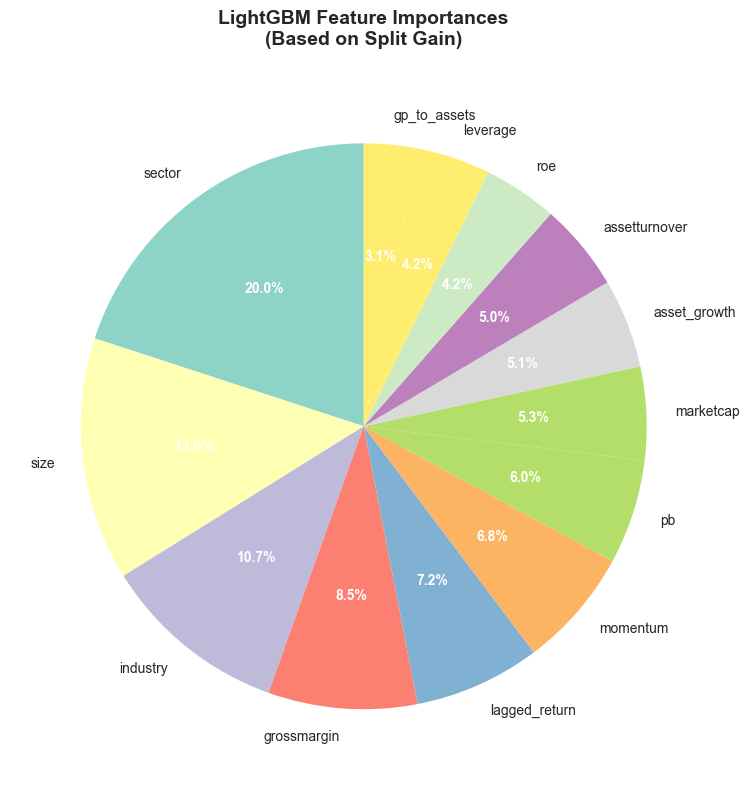

In [3]:
# Get feature importances (based on split gain)
feature_names = model.feature_name_
importances = model.feature_importances_

# Create dataframe and sort by importance
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("Feature Importances (sorted):")
print(feature_importance_df.to_string(index=False))

# Create pie chart
fig, ax = plt.subplots(figsize=(10, 8))

# Use a nice color palette
colors = plt.cm.Set3(np.linspace(0, 1, len(feature_importance_df)))

# Create pie chart with percentage labels
wedges, texts, autotexts = ax.pie(
    feature_importance_df['importance'],
    labels=feature_importance_df['feature'],
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    textprops={'fontsize': 10}
)

# Make percentage text bold and white
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

ax.set_title('LightGBM Feature Importances\n(Based on Split Gain)', 
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('model_feature_importances.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. Linear Regression on Percentile-Ranked Features

We convert all features to percentile ranks (matching the training data transformation) and run a linear regression to understand the linear component of how features relate to predictions.

In [4]:
# Identify feature columns (exclude ticker, predict, month, return, close)
exclude_cols = ['ticker', 'predict', 'month', 'return', 'close']
feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"Features for regression: {feature_cols}")

# Create a copy for ranked features
df_ranked = df[feature_cols].copy()

# Convert each feature to percentile rank
for col in feature_cols:
    df_ranked[col] = df[col].rank(pct=True)

print(f"\nSample of ranked features:")
print(df_ranked.head())

Features for regression: ['momentum', 'lagged_return', 'marketcap', 'pb', 'asset_growth', 'roe', 'gp_to_assets', 'grossmargin', 'assetturnover', 'leverage', 'sector', 'industry', 'size']

Sample of ranked features:
   momentum  lagged_return  marketcap        pb  asset_growth       roe  \
0  0.962231       0.936417   0.918919  0.992377      0.887041  0.983368   
1  0.963964       0.952529   0.809771  0.916667      0.647956  0.339570   
2  0.940055       0.991337   0.882190  0.977824      0.985447  0.047471   
3  0.984407       0.962578   0.892238  0.984061      0.909390  0.521310   
4  0.953569       0.967082   0.874913  0.893798      0.399515  0.344595   

   gp_to_assets  grossmargin  assetturnover  leverage    sector  industry  \
0      0.964657     0.419092       0.965350  0.408524  0.903846  0.296604   
1      0.325537     0.223146       0.428101  0.649342  0.903846  0.296604   
2      0.045218     0.910083       0.027547  0.345461  0.903846  0.296604   
3      0.752945     0.6212

In [5]:
# Run linear regression: predict ~ ranked features
X = df_ranked
y = df['predict']

# Fit model
lr = LinearRegression()
lr.fit(X, y)

# Get coefficients
coef_df = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': lr.coef_
}).sort_values('coefficient', ascending=False)

# Calculate R-squared
r_squared = lr.score(X, y)

print("\n" + "="*80)
print("LINEAR REGRESSION SUMMARY")
print("="*80)
print(f"\nDependent variable: predict (LightGBM predictions)")
print(f"Independent variables: {len(feature_cols)} percentile-ranked features")
print(f"\nIntercept: {lr.intercept_:.6f}")
print(f"R-squared: {r_squared:.4f}")
print(f"\nCoefficients (sorted by magnitude):")
print(coef_df.to_string(index=False))


LINEAR REGRESSION SUMMARY

Dependent variable: predict (LightGBM predictions)
Independent variables: 13 percentile-ranked features

Intercept: 0.402585
R-squared: 0.4609

Coefficients (sorted by magnitude):
      feature  coefficient
    marketcap     0.084629
lagged_return     0.059114
         size     0.043425
assetturnover     0.042240
       sector     0.031187
     momentum     0.021599
  grossmargin     0.012875
 asset_growth     0.011641
           pb     0.006837
          roe    -0.011316
 gp_to_assets    -0.018933
     leverage    -0.032146
     industry    -0.048095


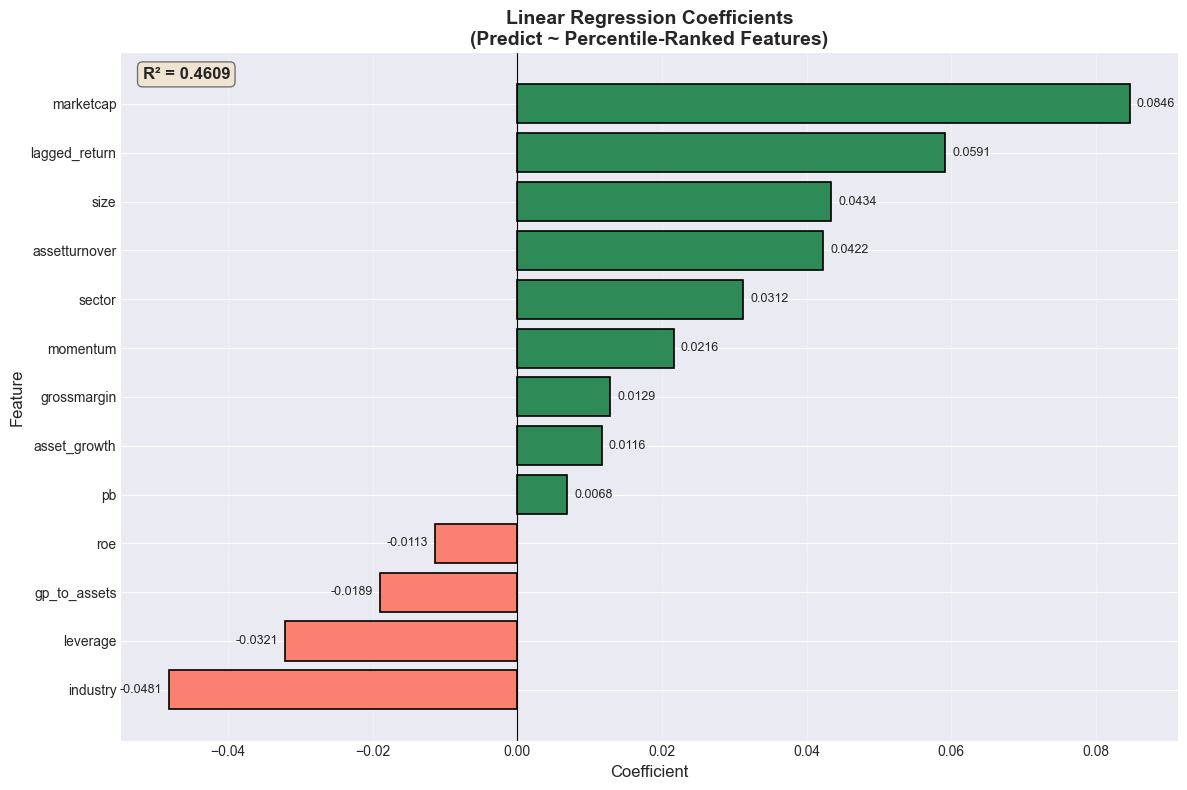

In [6]:
# Create bar chart of coefficients
fig, ax = plt.subplots(figsize=(12, 8))

# Sort by coefficient value for plotting
plot_df = coef_df.sort_values('coefficient')

# Create colors: positive = green, negative = red
colors = ['seagreen' if x > 0 else 'salmon' for x in plot_df['coefficient']]

# Create horizontal bar chart
bars = ax.barh(plot_df['feature'], plot_df['coefficient'], 
               color=colors, edgecolor='black', linewidth=1.2)

ax.set_xlabel('Coefficient', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Linear Regression Coefficients\n(Predict ~ Percentile-Ranked Features)', 
             fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (feature, coef) in enumerate(zip(plot_df['feature'], plot_df['coefficient'])):
    label_x = coef + (0.001 if coef > 0 else -0.001)
    ha = 'left' if coef > 0 else 'right'
    ax.text(label_x, i, f'{coef:.4f}', va='center', ha=ha, fontsize=9)

# Add R-squared annotation
ax.text(0.02, 0.98, f'R² = {r_squared:.4f}', 
        transform=ax.transAxes, fontsize=12, fontweight='bold',
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('regression_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Interpretation

### Feature Importance (LightGBM)
- Shows which features the model uses most frequently in its decision trees
- Based on split gain: how much each feature improves predictions when used for splitting
- Higher values indicate features that are more important for the model's decisions

### Regression Coefficients
- Shows the **linear relationship** between ranked features and predictions
- Positive coefficients: higher percentile → higher predicted return
- Negative coefficients: higher percentile → lower predicted return
- R-squared indicates how much of the prediction variance is explained by linear relationships

### Key Differences
1. **Feature importance** captures total usage including non-linear effects
2. **Regression coefficients** capture only the linear component
3. A feature can have high importance but low coefficient if its effect is primarily non-linear

In [7]:
# Compare importance ranks vs coefficient ranks
comparison = pd.merge(
    feature_importance_df.reset_index(drop=True),
    coef_df[['feature', 'coefficient']],
    on='feature'
)

comparison['importance_rank'] = range(1, len(comparison) + 1)
comparison['abs_coef'] = comparison['coefficient'].abs()
comparison = comparison.sort_values('abs_coef', ascending=False)
comparison['coef_rank'] = range(1, len(comparison) + 1)

comparison = comparison.sort_values('importance_rank')
comparison['rank_diff'] = comparison['coef_rank'] - comparison['importance_rank']

print("\n" + "="*80)
print("COMPARISON: FEATURE IMPORTANCE vs LINEAR COEFFICIENT")
print("="*80)
print("\nRank comparison (sorted by importance):")
print(comparison[['feature', 'importance', 'importance_rank', 
                  'coefficient', 'coef_rank', 'rank_diff']].to_string(index=False))

print("\nNote: Large rank differences suggest non-linear feature effects.")
print("Features with high importance but low coefficient rank may have")
print("strong non-linear or interaction effects captured by the tree model.")


COMPARISON: FEATURE IMPORTANCE vs LINEAR COEFFICIENT

Rank comparison (sorted by importance):
      feature  importance  importance_rank  coefficient  coef_rank  rank_diff
       sector         565                1     0.031187          7          6
         size         393                2     0.043425          4          2
     industry         302                3    -0.048095          3          0
  grossmargin         241                4     0.012875         10          6
lagged_return         204                5     0.059114          2         -3
     momentum         193                6     0.021599          8          2
           pb         169                7     0.006837         13          6
    marketcap         151                8     0.084629          1         -7
 asset_growth         144                9     0.011641         11          2
assetturnover         142               10     0.042240          5         -5
          roe         120               11    -